# **Introduction**

In this notebook, we focus more on pipeline metadata, and how to use that to be able to trace and debug our pipelines.

First, we create the pipeline we'll inspect throughout this notebook.

## Create the pipeline we will inspect

In [3]:
%%capture
!pip install dlt

In [4]:
import dlt
from dlt.sources.helpers import requests
from dlt.sources.helpers.rest_client import RESTClient
from dlt.sources.helpers.rest_client.auth import BearerTokenAuth
from dlt.sources.helpers.rest_client.paginators import HeaderLinkPaginator

import os
from google.colab import userdata

os.environ["SOURCES__SECRET_KEY"] = userdata.get('ACCESS_TOKEN')


@dlt.source
def github_source(secret_key=dlt.secrets.value):
    client = RESTClient(
            base_url="https://api.github.com",
            auth=BearerTokenAuth(token=secret_key),
            paginator=HeaderLinkPaginator(),
    )

    @dlt.resource
    def github_pulls(cursor_date=dlt.sources.incremental("updated_at", initial_value="2024-12-01")):
        params = {
            "since": cursor_date.last_value,
            "status": "open"
        }
        for page in client.paginate("repos/dlt-hub/dlt/pulls", params=params):
            yield page


    return github_pulls


# define new dlt pipeline
pipeline = dlt.pipeline(
    pipeline_name="github_pipeline",
    destination="duckdb",
    dataset_name="github_data",
)


# run the pipeline with the new resource
load_info = pipeline.run(github_source())
print(load_info)

Pipeline github_pipeline load step completed in 2.22 seconds
1 load package(s) were loaded to destination duckdb and into dataset github_data
The duckdb destination used duckdb:////content/github_pipeline.duckdb location to store data
Load package 1746895087.105192 is LOADED and contains no failed jobs


## Look at the data

In [5]:
import duckdb

conn = duckdb.connect(f"{pipeline.pipeline_name}.duckdb")

conn.sql("SHOW ALL TABLES").df()

,database,schema,name,column_names,column_types,temporary
0,github_pipeline,github_data,_dlt_loads,"[load_id, schema_name, status, inserted_at, sc...","[VARCHAR, VARCHAR, BIGINT, TIMESTAMP WITH TIME...",False
1,github_pipeline,github_data,_dlt_pipeline_state,"[version, engine_version, pipeline_name, state...","[BIGINT, BIGINT, VARCHAR, VARCHAR, TIMESTAMP W...",False
2,github_pipeline,github_data,_dlt_version,"[version, engine_version, inserted_at, schema_...","[BIGINT, BIGINT, TIMESTAMP WITH TIME ZONE, VAR...",False
3,github_pipeline,github_data,github_pulls,"[url, id, node_id, html_url, diff_url, patch_u...","[VARCHAR, BIGINT, VARCHAR, VARCHAR, VARCHAR, V...",False
4,github_pipeline,github_data,github_pulls__assignees,"[login, id, node_id, avatar_url, gravatar_id, ...","[VARCHAR, BIGINT, VARCHAR, VARCHAR, VARCHAR, V...",False
5,github_pipeline,github_data,github_pulls__base__repo__topics,"[value, _dlt_parent_id, _dlt_list_idx, _dlt_id]","[VARCHAR, VARCHAR, BIGINT, VARCHAR]",False
6,github_pipeline,github_data,github_pulls__head__repo__topics,"[value, _dlt_parent_id, _dlt_list_idx, _dlt_id]","[VARCHAR, VARCHAR, BIGINT, VARCHAR]",False
7,github_pipeline,github_data,github_pulls__labels,"[id, node_id, url, name, color, default, descr...","[BIGINT, VARCHAR, VARCHAR, VARCHAR, VARCHAR, B...",False
8,github_pipeline,github_data,github_pulls__requested_reviewers,"[login, id, node_id, avatar_url, gravatar_id, ...","[VARCHAR, BIGINT, VARCHAR, VARCHAR, VARCHAR, V...",False


More importantly, let's look at the saved load info

In [6]:
conn.sql("select * from github_data._dlt_loads").df()

,load_id,schema_name,status,inserted_at,schema_version_hash
0,1746895087.105192,github_source,0,2025-05-10 16:38:10.688259+00:00,PFX9VoFpCl/AA3bY+A/mM1b/6V67woKy33y30GOZQLw=


# **Tracing with Sentry**



You can enable tracing through Sentry.

## What is `Sentry` 🤔

`Sentry` is an open-source error tracking and performance monitoring tool that helps developers **identify**, **monitor**, and **fix issues** in real-time in their applications.


Remember, `dlt` does not have the `Sentry` client as a dependency. You need to install it.

In [7]:
%%capture
!pip install sentry-sdk

In [8]:
import sentry_sdk

### Sentry needs to be initialized in normal scripts



```
import sentry_sdk
import os

sentry_sdk.init(
    dsn=os.getenv("RUNTIME__SENTRY_DSN"),
    traces_sample_rate=1.0  # Adjust this for performance monitoring if needed
)
```



### Say, you make an error and it is caught with Sentry:



```
try:
    1 / 0
except ZeroDivisionError as e:
    sentry_sdk.capture_exception(e)

```



It will then show up on your Sentry dashboard:
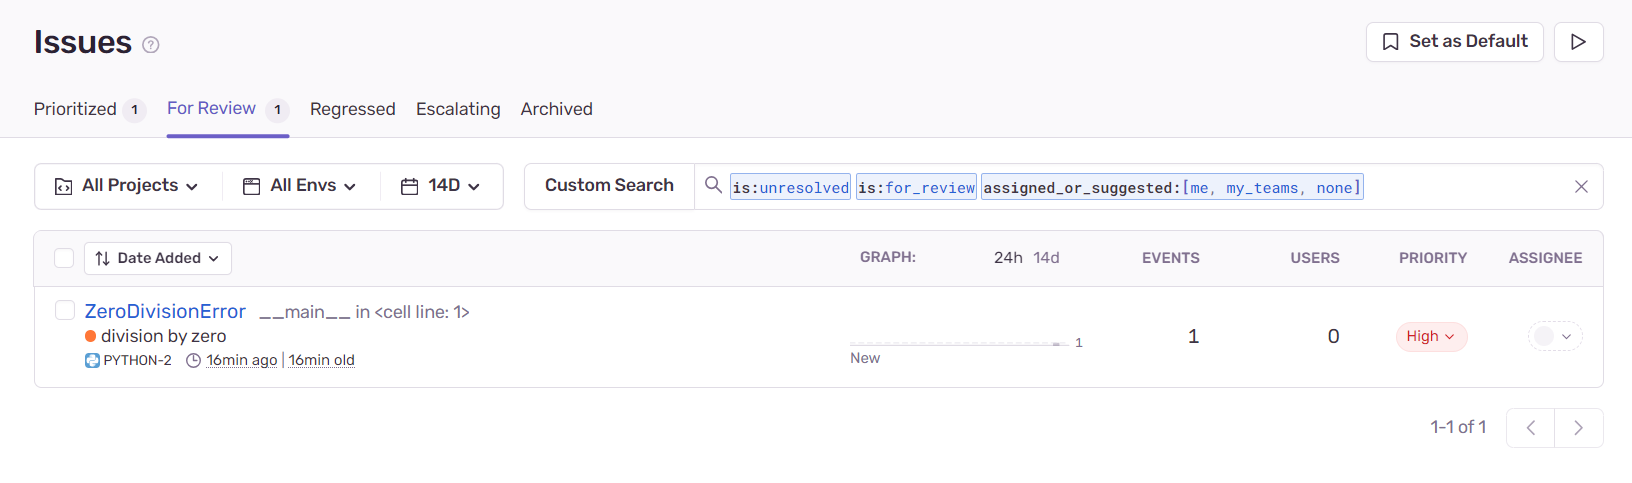

Even when a normal error arises after Sentry has been initiated, your program executes normally, but sends that error to your dashboard, so it can be tracked!

### In dlt, you can enable Sentry quite easily

You can configure the `DSN` in the `config.toml`:

```
[runtime]

sentry_dsn="https:///<...>"
```


Alternatively, you can use environment variables. **This is what we'll be doing**:
```
RUNTIME__SENTRY_DSN="https:///<...>"
```
The entry client is configured after the first pipeline is created with `dlt.pipeline()`. Feel free to use `sentry_sdk` init again to cover your specific needs.

Let's try introducing the same error again

In [9]:
import os
from google.colab import userdata

os.environ['RUNTIME__SENTRY_DSN'] = userdata.get('SENTRY_TOKEN')

SecretNotFoundError: Secret SENTRY_TOKEN does not exist.

In [ ]:
data = {
    12: 34
}

info = pipeline.run([data], table_name='issues')
info

And that comes up in Sentry as well

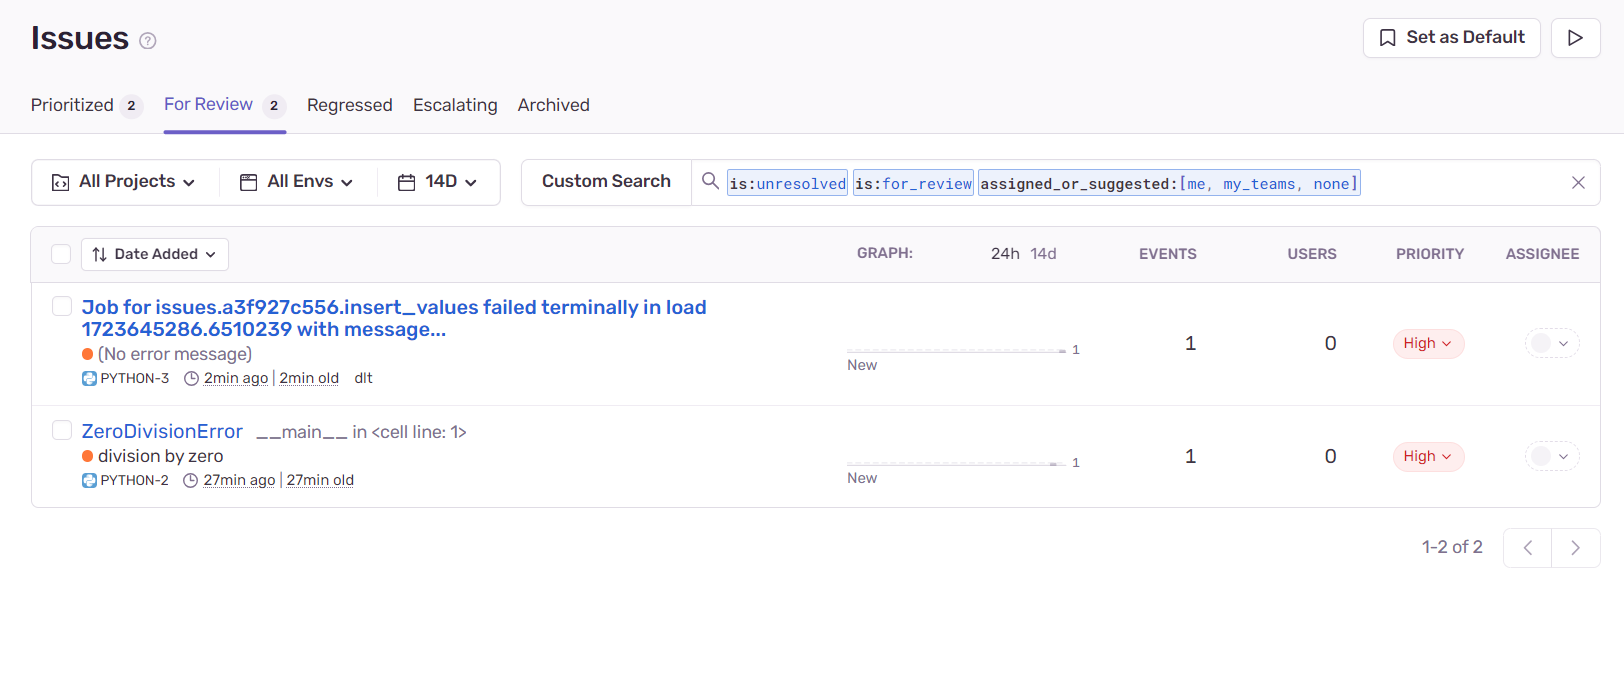

The message sent to Sentry is:
```
Job for issues.a3f927c556.insert_values failed terminally in load 1723645286.6510239 with message Constraint Error: NOT NULL constraint failed: issues.id
```



# **Logging**

There are various environments where we would be completely lost without logs.

Debugging any system would be incredibly hard if we didn't know what was going on, or at what point the program ran into an error.

### Setting log levels in `dlt`

You can set log levels in your `config.toml` file:



```
[runtime]
log_level="INFO"
```

`log_level` accepts the Python standard logging level names.

The default log level is `WARNING`.

**`INFO` log level is useful when diagnosing problems in production.**

**`CRITICAL` will disable logging.**

**`DEBUG` should not be used in production.**

We'll be setting the log level in our environment variables:

In [10]:
import os
os.environ['RUNTIME__LOG_LEVEL'] = 'INFO'

dlt logs to a logger named `dlt`.

dlt logger uses a regular python logger so you can configure the handlers as per your requirement.

In [11]:
import logging

# Create a logger
logger = logging.getLogger('dlt')

# Set the log level
logger.setLevel(logging.INFO)

# Create a file handler
handler = logging.FileHandler('dlt.log')

# Add the handler to the logger
logger.addHandler(handler)

In [12]:
# USING LOGGER
pipeline = dlt.pipeline(
    pipeline_name="github_issues_merge_logger",
    destination="duckdb",
    dataset_name="github_data_merge",
)
load_info = pipeline.run(github_source())

# result gets showed despite no print statement ? check dlt.log

2025-05-10 16:39:26,496|[INFO]|1219|138608634167296|dlt|__init__.py|bind:482|Bind incremental on github_pulls with initial_value: 2024-12-01, start_value: 2024-12-01, end_value: None
2025-05-10 16:39:26,498|[INFO]|1219|138608634167296|dlt|client.py|_send_request:127|Making GET request to https://api.github.com/repos/dlt-hub/dlt/pulls with params={'since': '2024-12-01', 'status': 'open'}, json=None with headers={}
2025-05-10 16:39:26,962|[INFO]|1219|138608634167296|dlt|client.py|detect_data_selector:286|Detected page data at path: '$' type: list length: 30
2025-05-10 16:39:26,998|[INFO]|1219|138608634167296|dlt|client.py|extract_response:267|Extracted data of type list from path $ with length 30
2025-05-10 16:39:27,042|[INFO]|1219|138608634167296|dlt|client.py|_send_request:127|Making GET request to https://api.github.com/repositories/452221115/pulls?since=2024-12-01&status=open&page=2 with params=None, json=None with headers={}
2025-05-10 16:39:27,236|[INFO]|1219|138608634167296|dlt|cl

### Logging via `Loguru` in our GitHub example

In [13]:
%%capture
!pip install loguru

let's change the logging level

In [14]:
import os
os.environ['RUNTIME__LOG_LEVEL'] = 'INFO'

In [15]:
import logging
import sys

import dlt
from loguru import logger


# parent class logging.Handler processes log messages
class InterceptHandler(logging.Handler):

    # decorator provided by loguru that catches any exceptions in the decorated function and logs them
    @logger.catch(default=True, onerror=lambda _: sys.exit(1))
    def emit(self, record):
        # Get corresponding Loguru level if it exists.
        try:
            level = logger.level(record.levelname).name
        except ValueError:
            level = record.levelno

        # Find caller (call frame) from where originated the logged message.
        frame, depth = sys._getframe(6), 6
        while frame and frame.f_code.co_filename == logging.__file__:
            frame = frame.f_back
            depth += 1

        # logs the message using loguru, with the level, exception information, and depth
        logger.opt(depth=depth, exception=record.exc_info).log(level, record.getMessage())

logger_dlt = logging.getLogger("dlt")
logger_dlt.addHandler(InterceptHandler())

# all logs will be written to dlt_loguru.log
logger.add("dlt_loguru.log");

In [16]:
# using loguru logger
pipeline = dlt.pipeline(
    pipeline_name="github_issues_merge_loguru",
    destination="duckdb",
    dataset_name="github_data_merge",
)
load_info = pipeline.run(github_source())

2025-05-10 16:39:42,031|[INFO]|1219|138608634167296|dlt|__init__.py|bind:482|Bind incremental on github_pulls with initial_value: 2024-12-01, start_value: 2024-12-01, end_value: None
2025-05-10 16:39:42.050 | INFO     | dlt.common.logger:wrapper:24 - Bind incremental on github_pulls with initial_value: 2024-12-01, start_value: 2024-12-01, end_value: None
2025-05-10 16:39:42,054|[INFO]|1219|138608634167296|dlt|client.py|_send_request:127|Making GET request to https://api.github.com/repos/dlt-hub/dlt/pulls with params={'since': '2024-12-01', 'status': 'open'}, json=None with headers={}
2025-05-10 16:39:42.058 | INFO     | dlt.common.logger:wrapper:24 - Making GET request to https://api.github.com/repos/dlt-hub/dlt/pulls with params={'since': '2024-12-01', 'status': 'open'}, json=None with headers={}
2025-05-10 16:39:42,519|[INFO]|1219|138608634167296|dlt|client.py|detect_data_selector:286|Detected page data at path: '$' type: list length: 30
2025-05-10 16:39:42.524 | INFO     | dlt.commo

## **Logs for monitoring the progress**

In [17]:
import os
os.environ['RUNTIME__LOG_LEVEL'] = 'WARNING'


pipeline = dlt.pipeline(
    pipeline_name="github_issues_progress",
    destination="duckdb",
    dataset_name="github_data_merge",
    progress="log"
)
load_info = pipeline.run(github_source())

---------------------------- Extract github_source -----------------------------
Resources: 0/1 (0.0%) | Time: 0.00s | Rate: 0.00/s
Memory usage: 299.33 MB (10.50%) | CPU usage: 0.00%

---------------------------- Extract github_source -----------------------------
Resources: 0/1 (0.0%) | Time: 0.51s | Rate: 0.00/s
github_pulls: 30  | Time: 0.00s | Rate: 2169467.59/s
Memory usage: 302.42 MB (10.70%) | CPU usage: 0.00%

---------------------------- Extract github_source -----------------------------
Resources: 1/1 (100.0%) | Time: 0.80s | Rate: 1.26/s
github_pulls: 33  | Time: 0.29s | Rate: 114.02/s
Memory usage: 302.68 MB (10.70%) | CPU usage: 0.00%

---------------------------- Extract github_source -----------------------------
Resources: 0/1 (0.0%) | Time: 0.00s | Rate: 0.00/s
Memory usage: 302.68 MB (10.70%) | CPU usage: 0.00%

---------------------------- Extract github_source -----------------------------
Resources: 0/1 (0.0%) | Time: 0.01s | Rate: 0.00/s
_dlt_pipeline_state: 1  

✅ ▶ Proceed to the [next lesson](https://colab.research.google.com/drive/11P5O2R40ExtFtPfX4o1O5mF7nFbibtuZ#forceEdit=true&sandboxMode=true)!